In [4]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

# Reading Data

In [5]:
def segmentWords(s): 
    return s.split()

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [6]:
d = []

for c in os.listdir("data_training"):
    directory = "data_training/" + c
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        e['__FileID__'] = file
        e['__CLASS__'] = c
        d.append(e)

Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [7]:
df = pd.DataFrame.from_dict(data=d)
df = df.fillna(value = 0)


#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [8]:
df_train = df.sample(frac=0.8)
df_valid = df.drop(df_train.index)

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [9]:
train_x = df_train.drop(labels =['__FileID__','__CLASS__'], axis = 1)
train_y = df_train['__CLASS__']

valid_x = df_valid.drop(labels =['__FileID__','__CLASS__'], axis = 1)
valid_y = df_valid['__CLASS__']

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#Prediction for training data
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
logreg.score(train_x, train_y)

1.0

In [11]:
#cross-validation
scores = cross_val_score(logreg, valid_x, valid_y, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

[ 0.63636364  0.75757576  0.65625     0.78125     0.78125     0.78125
  0.9375      0.65625     0.67741935  0.90322581]
average score: 0.7568334555229718


Given the test accuracy of 100% vs. the average validation accuracy of 75.9%, it is very clear that there is a case of overfitting. 

#### Changing Parameters

In [12]:
for p in ['l1', 'l2']:
    for c in [0.001, 0.01, 0.1, 1]:
        lr_param = LogisticRegression(C = c, penalty = p)
        lr_param.fit(train_x, train_y)
        print("C = " + str(format(c, '.3f')) + ", penalty = " + str(p) + ", Train score = " + 
              str(format(lr_param.score(train_x,train_y), '.3f'))
             + ",  Test score = " + str(format(lr_param.score(valid_x,valid_y), '.3f')))

C = 0.001, penalty = l1, Train score = 0.514,  Test score = 0.447
C = 0.010, penalty = l1, Train score = 0.684,  Test score = 0.675
C = 0.100, penalty = l1, Train score = 0.902,  Test score = 0.822
C = 1.000, penalty = l1, Train score = 1.000,  Test score = 0.828
C = 0.001, penalty = l2, Train score = 0.869,  Test score = 0.809
C = 0.010, penalty = l2, Train score = 0.993,  Test score = 0.853
C = 0.100, penalty = l2, Train score = 1.000,  Test score = 0.866
C = 1.000, penalty = l2, Train score = 1.000,  Test score = 0.866


#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

In [13]:
weights = (np.array(logreg.coef_[0])-np.mean(logreg.coef_[0]))/np.std(logreg.coef_[0])
train_x_bss = train_x.iloc[:, np.where(np.abs(weights)>1)[0].tolist()]
test_x_bss = valid_x.iloc[:, np.where(np.abs(weights)>1)[0].tolist()]

for p in ['l1', 'l2']:
    for c in [0.001, 0.01, 0.1, 1]:
        lr3 = LogisticRegression(C=c, penalty=p)
        lr3.fit(train_x_bss, train_y)
        print("C = " + str(format(c, '.3f')) + ", penalty = " + str(p) + ", Train score = " + 
                  str(format(lr3.score(train_x_bss, train_y), '.3f'))
                 + ",  Test score = " + str(format(lr3.score(test_x_bss, valid_y), '.3f')))

C = 0.001, penalty = l1, Train score = 0.514,  Test score = 0.447
C = 0.010, penalty = l1, Train score = 0.696,  Test score = 0.666
C = 0.100, penalty = l1, Train score = 0.900,  Test score = 0.819
C = 1.000, penalty = l1, Train score = 1.000,  Test score = 0.825
C = 0.001, penalty = l2, Train score = 0.863,  Test score = 0.784
C = 0.010, penalty = l2, Train score = 0.993,  Test score = 0.866
C = 0.100, penalty = l2, Train score = 1.000,  Test score = 0.863
C = 1.000, penalty = l2, Train score = 1.000,  Test score = 0.844


How did you select which features to remove? Why did that reduce overfitting?

Features were removed based on weight. Based on the results seen above, C = 0.010, and penalty = l2 proved to perform well and decrease overfitting on the training set. 

# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [14]:
dtree = DecisionTreeClassifier() 
dtree = dtree.fit(train_x, train_y)
print("Train accuracy: " + str(dtree.score(train_x, train_y)))
print("Test accuracy: " + str(dtree.score(valid_x, valid_y)))

Train accuracy: 1.0
Test accuracy: 0.603125


#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

In [15]:
c = np.shape(train_y)
r = np.shape(train_y)
train_y_reshape = np.reshape(train_y, (c))

params = {"max_leaf_nodes": [50,100,150,200]}
gscv = model_selection.GridSearchCV(dtree, params)
gscv = gscv.fit(train_x.values, train_y_reshape.values.reshape(c))

/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [16]:
gscv.cv_results_

/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alex/anaconda3/lib/python3.6/site

{'mean_fit_time': array([ 6.8609492 ,  7.68731435,  8.21607272,  8.18915423]),
 'mean_score_time': array([ 0.0274121 ,  0.02619664,  0.02625505,  0.02632125]),
 'mean_test_score': array([ 0.63828125,  0.6453125 ,  0.64140625,  0.63984375]),
 'mean_train_score': array([ 0.91483601,  0.99843689,  1.        ,  1.        ]),
 'param_max_leaf_nodes': masked_array(data = [50 100 150 200],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'max_leaf_nodes': 50},
  {'max_leaf_nodes': 100},
  {'max_leaf_nodes': 150},
  {'max_leaf_nodes': 200}],
 'rank_test_score': array([4, 1, 2, 3], dtype=int32),
 'split0_test_score': array([ 0.64485981,  0.64485981,  0.64252336,  0.64953271]),
 'split0_train_score': array([ 0.90492958,  0.99765258,  1.        ,  1.        ]),
 'split1_test_score': array([ 0.64084507,  0.64553991,  0.65023474,  0.64319249]),
 'split1_train_score': array([ 0.91217799,  0.99765808,  1.        ,  1.        ]),
 'split2_test_score': array([ 0.629

In [17]:
x = [50,100,150,200]
y = [tree.DecisionTreeClassifier(max_depth=k).fit(train_x,train_y_reshape).score(valid_x,valid_y) for k in x]

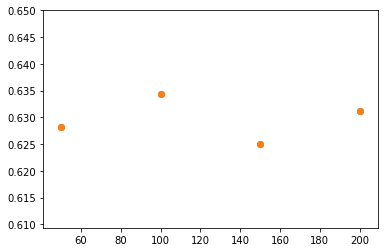

In [21]:
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.show()

Why is a single decision tree so prone to overfitting?

# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_x, train_y)
print("Default score for training data: " + str(clf.score(train_x, train_y)))
print("Default score for test data: " + str(clf.score(valid_x, valid_y)))

Default score for training data: 0.9921875
Default score for test data: 0.65


#### Changing Parameters

In [20]:
clf.set_params(n_estimators=400, criterion="entropy")
clf.fit(train_x, train_y)
print("Default score for training data: " + str(clf.score(train_x, train_y)))
print("Default score for test data: " + str(clf.score(valid_x, valid_y)))

Default score for training data: 1.0
Default score for test data: 0.815625


What parameters did you choose to change and why?

I set n_estimators to 400 because this creates more estimators, and the model at the end that merges all the different estimators will be better because outliers will disappear and the best features are selected. I also chose to use information gain ("entropy") to measure the quality of splits because it is better for attributes that occur in classes. Changing the other parameters did not appear to affect the scores significantly (changes from the default value).

How does a random forest classifier prevent overfitting better than a single decision tree?

A random forest classifier prevents overfitting better than a single decision tree because each tree in the forest gets different data, so the features that are detected will be different at the end. Bootstrapping aggregation is when points that are repeated in the data are weighted more when the trees are merged together. This minimizes outliers and prevents overfitting. Each tree also randomly selects features, so the random forest classifier will take the average of all the selections and have the best set of features. This also makes the random forest classifier stronger, so it will not overfit as much as a single decision tree.